In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from imblearn.over_sampling import SMOTE

Load libraries for data handling and visualization

In [305]:
# load data
df = pd.read_csv('synthetic_loan_data.csv')
df

,CustomerID,Name,Age,Gender,MaritalStatus,EducationLevel,EmploymentStatus,AnnualIncome,LoanAmountRequested,PurposeOfLoan,CreditScore,ExistingLoansCount,LatePaymentsLastYear,LoanApproved
0,bdd640fb-0667-4ad1-9c80-317fa3b1799d,Michelle Prince,56,Male,Divorced,Other,Employed,97622,46413,Personal,500,2,4,Yes
1,23b8c1e9-3924-46de-beb1-3b9046685257,Diana Mullins,69,Male,Married,Bachelor,Employed,96925,24065,Home,532,2,0,Yes
2,bd9c66b3-ad3c-4d6d-9a3d-1fa7bc8960a9,Brittany Ballard,46,Female,Single,High School,Self-employed,167927,46676,Personal,795,2,6,Yes
3,972a8469-1641-4f82-8b9d-2434e465e150,Matthew Freeman,32,Female,Widowed,PhD,Unemployed,112920,27406,Education,376,2,9,No
4,17fc695a-07a0-4a6e-8822-e8f36c031199,Amy Baker,60,Female,Widowed,Master,Unemployed,152183,49337,Car,517,3,7,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,bdcfc42b-8122-41db-aa6a-58b294568b74,Jose Torres,22,Female,Divorced,Other,Student,178359,48541,Education,363,2,8,Yes
8996,a874d557-cd0e-4708-acbf-81d4b1720b65,Michael Butler,26,Female,Widowed,Other,Self-employed,126938,33411,Education,379,4,7,Yes
8997,8a4f48b2-d251-43ad-880b-dbd7657050ee,Veronica Avila,19,Male,Married,PhD,Student,119957,47023,Car,693,2,6,Yes
8998,8d5af123-085d-47e6-872c-5869d4c933f2,Kayla Miller,51,Female,Married,PhD,Retired,160226,31385,Personal,649,4,7,No


Load dataset to read its content

In [306]:
# data overview
print(df.shape)
print(df.info())
print(df.describe())

(9000, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   CustomerID            9000 non-null   object
 1   Name                  9000 non-null   object
 2   Age                   9000 non-null   int64 
 3   Gender                9000 non-null   object
 4   MaritalStatus         9000 non-null   object
 5   EducationLevel        9000 non-null   object
 6   EmploymentStatus      9000 non-null   object
 7   AnnualIncome          9000 non-null   int64 
 8   LoanAmountRequested   9000 non-null   int64 
 9   PurposeOfLoan         9000 non-null   object
 10  CreditScore           9000 non-null   int64 
 11  ExistingLoansCount    9000 non-null   int64 
 12  LatePaymentsLastYear  9000 non-null   int64 
 13  LoanApproved          9000 non-null   object
dtypes: int64(6), object(8)
memory usage: 984.5+ KB
None
               Age   Annu

Checks the number of rows and columns, nulls and statistical summary of data

In [307]:
df = df.drop(["CustomerID", "Name"], axis=1)

Dropping unecessary columns cleans the data as they add no value to prediction, the redundant columns will cause noise to the model which can cause overfitting and data leakage.

In [308]:
print(df.isnull().sum())

Age                     0
Gender                  0
MaritalStatus           0
EducationLevel          0
EmploymentStatus        0
AnnualIncome            0
LoanAmountRequested     0
PurposeOfLoan           0
CreditScore             0
ExistingLoansCount      0
LatePaymentsLastYear    0
LoanApproved            0
dtype: int64


Checks for columns with missing data for cleaning, since there is no missing data, dataset is clean.

In [309]:
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    print(f"{col}: {df[col].unique()}")

Gender: ['Male' 'Female']
MaritalStatus: ['Divorced' 'Married' 'Single' 'Widowed']
EducationLevel: ['Other' 'Bachelor' 'High School' 'PhD' 'Master']
EmploymentStatus: ['Employed' 'Self-employed' 'Unemployed' 'Retired' 'Student']
PurposeOfLoan: ['Personal' 'Home' 'Education' 'Car' 'Business']
LoanApproved: ['Yes' 'No']


Checks for categories that may need to be encoded later on for the model to learn from

In [ ]:
df['AnnualIncome'] = pd.to_numeric(df['AnnualIncome'], errors='coerce')
df['LoanAmountRequested'] = pd.to_numeric(df['LoanAmountRequested'], errors='coerce')

df['Loan_to_Income'] = df['LoanAmountRequested'] / (df['AnnualIncome'] + 1)

df['Loan_to_Income'].fillna(df['Loan_to_Income'].median(), inplace=True)

df[['LoanAmountRequested', 'AnnualIncome', 'Loan_to_Income']].head()

C:\Users\chaya\AppData\Local\Temp\ipykernel_17640\1083209142.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Loan_to_Income'].fillna(df['Loan_to_Income'].median(), inplace=True)


,LoanAmountRequested,AnnualIncome,Loan_to_Income
0,46413,97622,0.475431
1,24065,96925,0.248282
2,46676,167927,0.277952
3,27406,112920,0.242701
4,49337,152183,0.324193


Ensures loan and income are numeric, create a new ratio feature and fill any null value with the median

LoanApproved
Yes    6303
No     2697
Name: count, dtype: int64


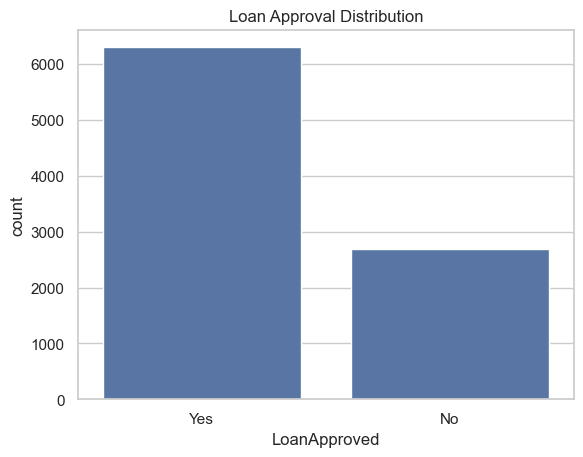

In [311]:
# Check class distribution for target
print(df['LoanApproved'].value_counts())

# Visualize target distribution
sns.countplot(x='LoanApproved', data=df)
plt.title('Loan Approval Distribution')
plt.show()

Checks for class imbalance and plot distribution.
70% of loans are approved which is quite imbalanced.

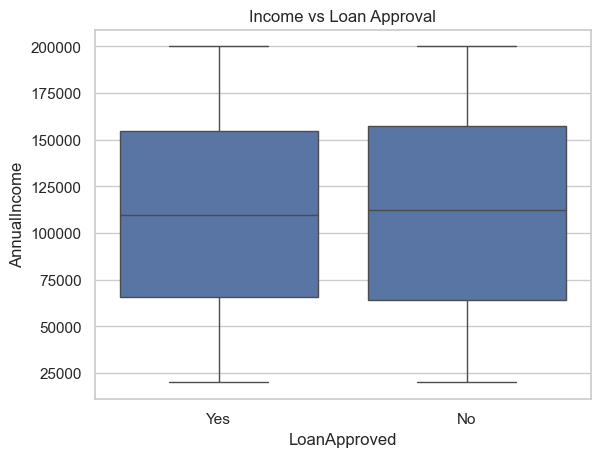

In [312]:
sns.boxplot(x='LoanApproved', y='AnnualIncome', data=df)
plt.title('Income vs Loan Approval')
plt.show()

See how numeric features differ between approved and not approved loans.
There are no visible difference in median or spread so income is likely not a strong predictor.

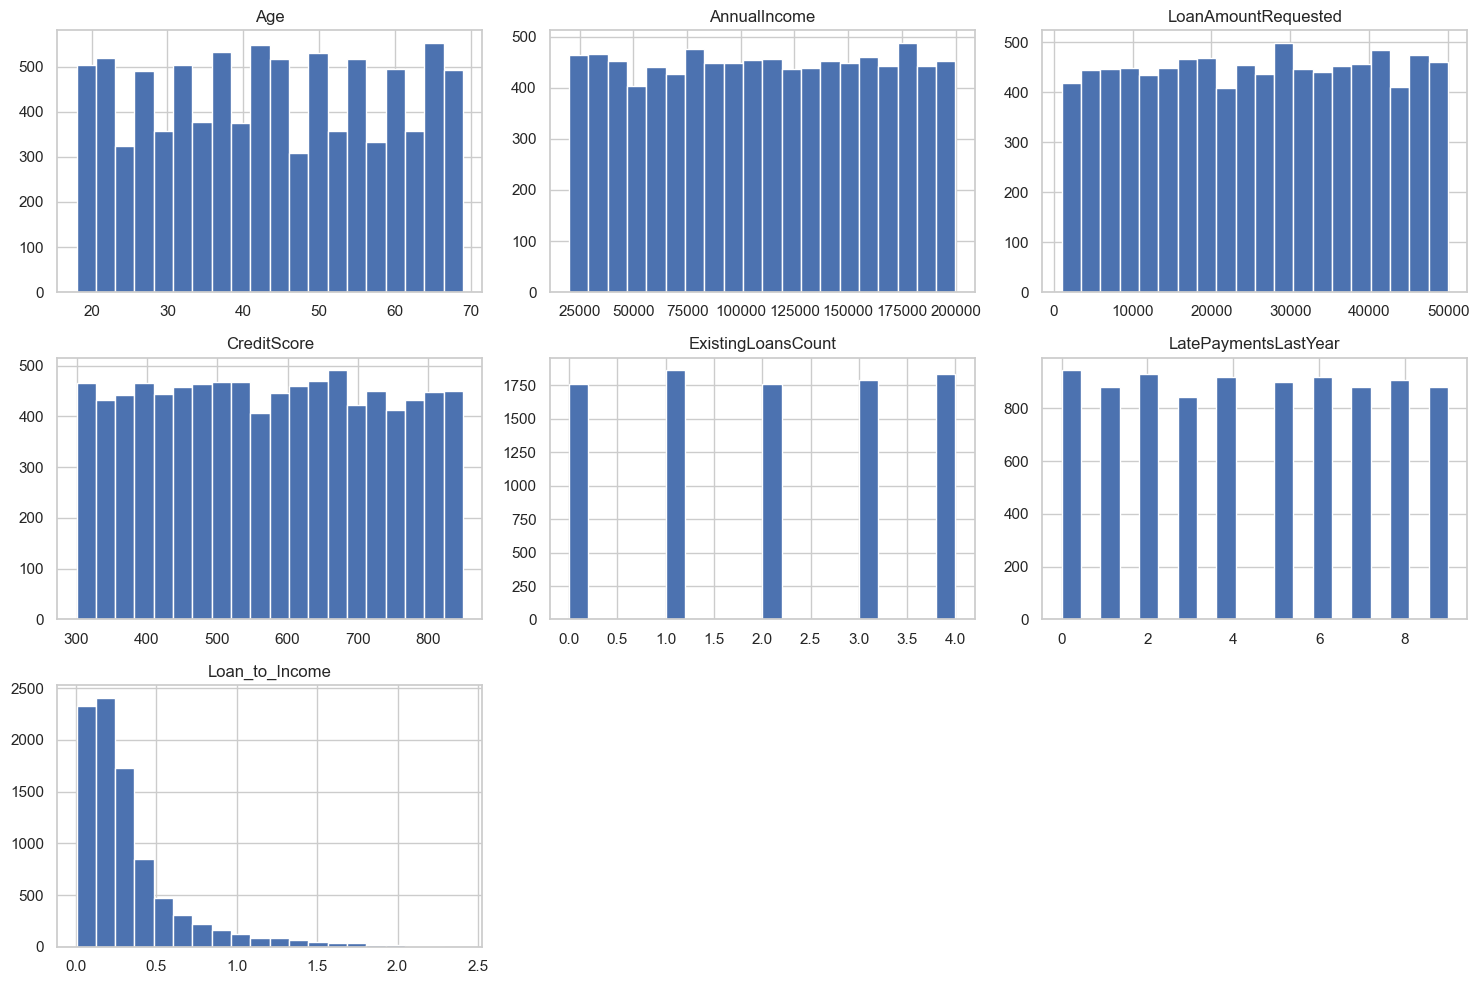

In [313]:
# Histogram for numeric columns
df.hist(bins=20, figsize=(15,10))
plt.tight_layout()
plt.show()

Plots numeric values and checks for outliers.
Most graphs have a consistent trend but Age has fluctuating trend which could indicate that Age is a stronger predictor when it comes to model prediction.

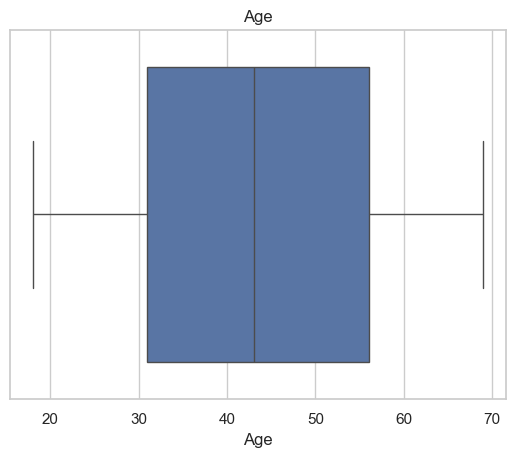

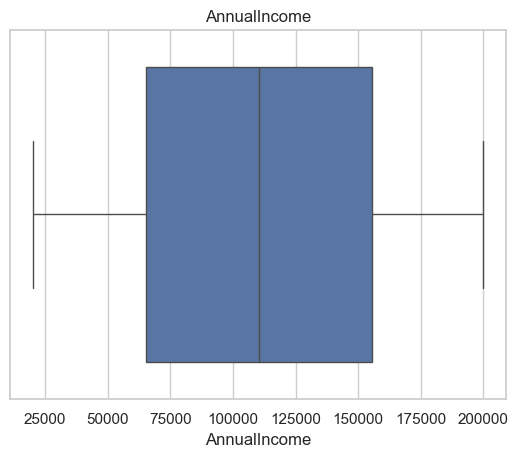

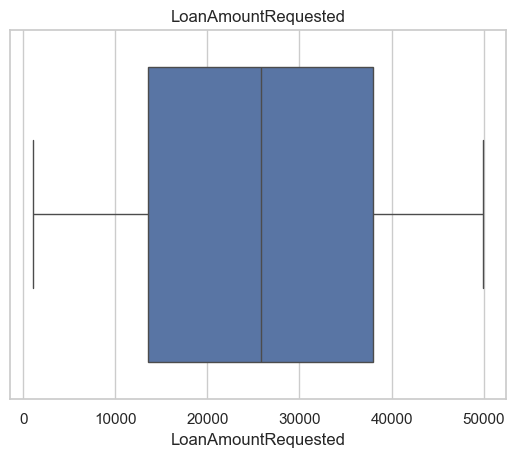

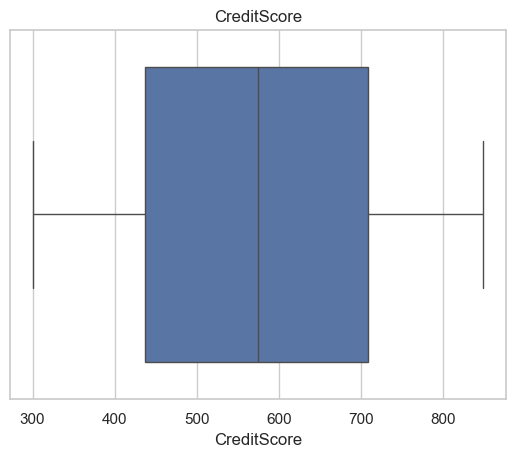

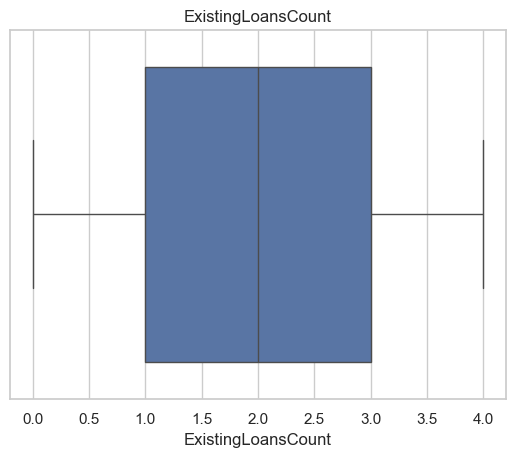

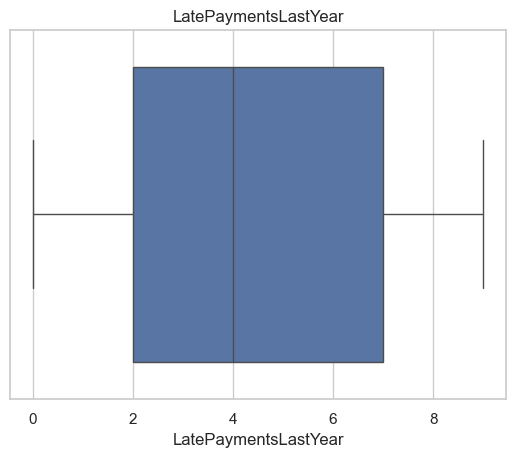

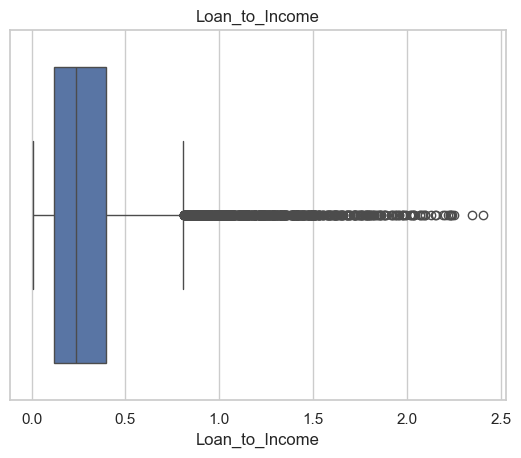

In [314]:
# Boxplots for outlier detection
for col in df.select_dtypes(include='number').columns:
    plt.figure()
    sns.boxplot(x=df[col])
    plt.title(col)
    plt.show()

visual check for which numeric feature differ most by outcome

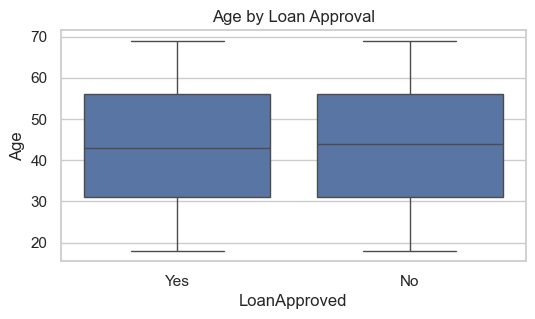

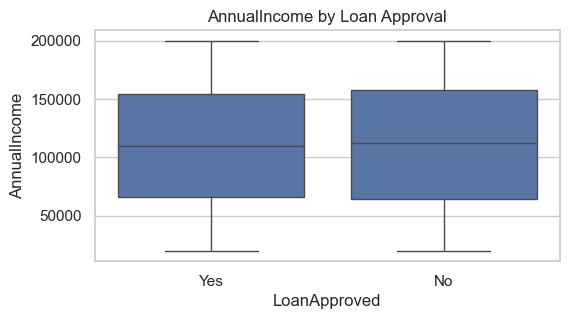

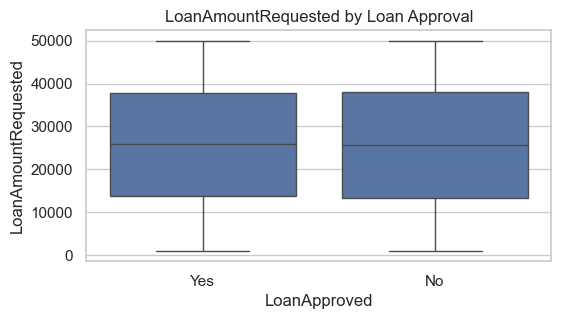

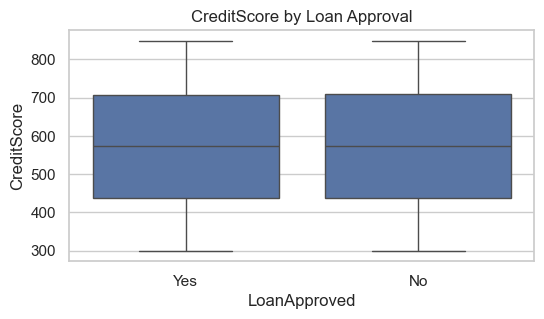

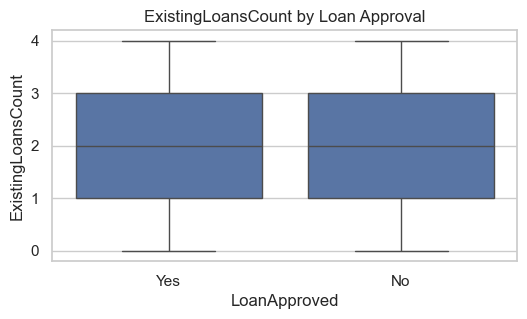

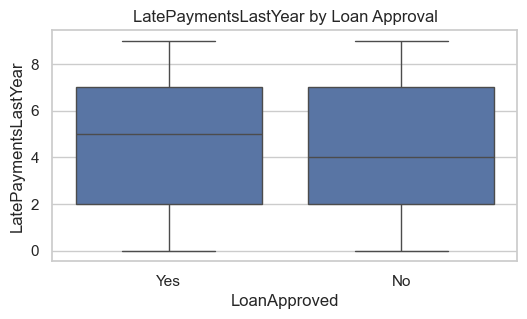

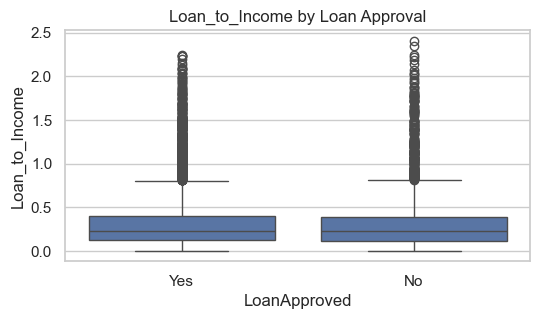

In [315]:
# Boxplots for numerical features grouped by target
# see which features differ most between approved and not approved loans
num_cols = df.select_dtypes(include='number').columns
for col in num_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x='LoanApproved', y=col, data=df)
    plt.title(f'{col} by Loan Approval')
    plt.show()

Visualise and identify distributions to spot outliers

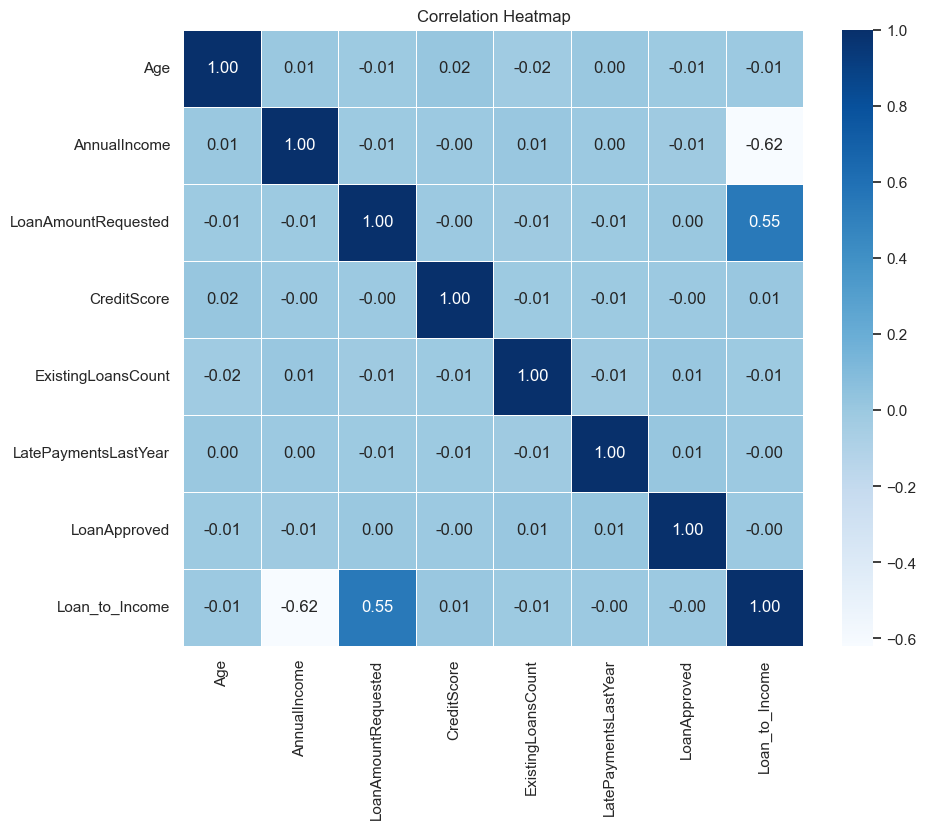

In [348]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='Blues', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()


The heatmap shows there is a strong correlation between LoanAmountRequested and Loan_to-Income while a weak correlation of CreditScore with others.

 Higher income applicants tend to get approved more (visible in the boxplot).
- Education level appears balanced, with most being graduates.
- The correlation heatmap shows that Credit_History and LoanAmount are important features.
- A new feature `Loan_to_Income` has been added to capture affordability.

In [317]:
# Compare means by target
print(df.groupby('LoanApproved').mean(numeric_only=True))

# Categorical features vs target
for col in categorical_cols:
    if col != 'LoanApproved':
        print(df.groupby(col)['LoanApproved'].value_counts(normalize=True))

                    Age   AnnualIncome  LoanAmountRequested  CreditScore  \
LoanApproved                                                               
No            43.701149  111281.496478         25634.187616   573.768632   
Yes           43.485959  109851.194828         25700.435666   572.947168   

              ExistingLoansCount  LatePaymentsLastYear  Loan_to_Income  
LoanApproved                                                            
No                      1.989989              4.412310        0.332043  
Yes                     2.016341              4.502459        0.329374  
Gender  LoanApproved
Female  Yes             0.707219
        No              0.292781
Male    Yes             0.693484
        No              0.306516
Name: proportion, dtype: float64
MaritalStatus  LoanApproved
Divorced       Yes             0.691189
               No              0.308811
Married        Yes             0.696507
               No              0.303493
Single         Yes           

See proportion of loan approvals within each category

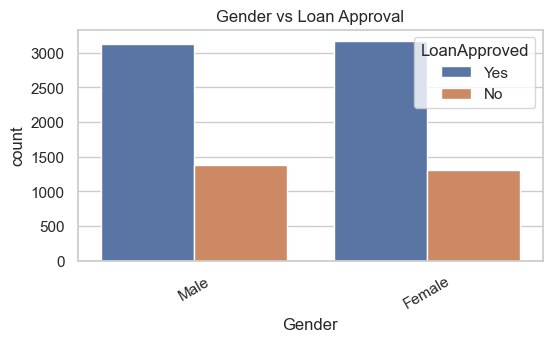

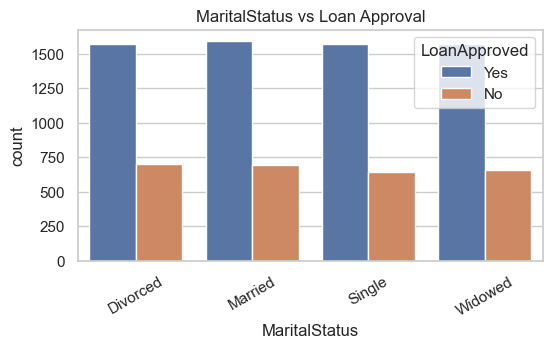

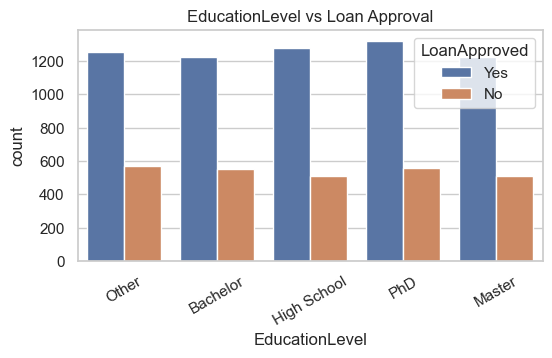

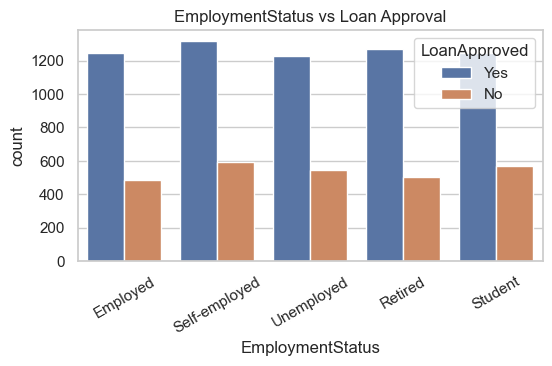

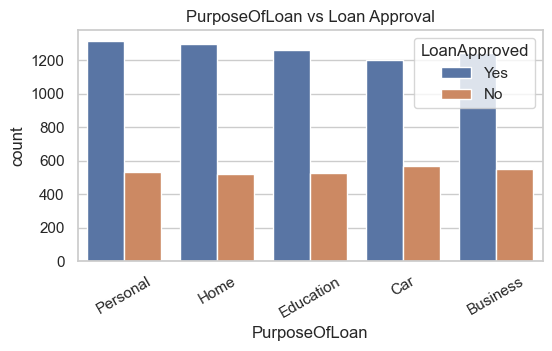

In [318]:
# Bar plots for categorical features vs target
cat_cols = [col for col in categorical_cols if col != 'LoanApproved']
for col in cat_cols:
    plt.figure(figsize=(6, 3))
    sns.countplot(x=col, hue='LoanApproved', data=df)
    plt.title(f'{col} vs Loan Approval')
    plt.xticks(rotation=30)
    plt.show()

Visualise relationship between categorical features and loan approval and compares approval rates within each category

Model building and evaluation

In [319]:
df_encoded = pd.get_dummies(df, drop_first=True)

convert categorical features to be used for modeling

In [320]:
df["LoanApproved"] = df["LoanApproved"].map({"Yes": 1, "No": 0})

In [ ]:
iso = IsolationForest(contamination=0.02, random_state=42)
df_encoded['anomaly'] = iso.fit_predict(df_encoded.drop("LoanApproved_Yes", axis=1))

df_cleaned = df_encoded[df_encoded["anomaly"] == 1].drop("anomaly", axis=1)

In [322]:
df_cleaned['LoanApproved_Yes'].value_counts(normalize=True)


LoanApproved_Yes
True     0.701247
False    0.298753
Name: proportion, dtype: float64

In [323]:
from imblearn.over_sampling import SMOTE

X = df_cleaned.drop('LoanApproved_Yes', axis=1)
y = df_cleaned['LoanApproved_Yes']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [324]:
df_encoded['DebtToIncome'] = df_encoded['LoanAmountRequested'] / (df_encoded['AnnualIncome'] + 1)

Higher ratio suggests a riskier borrower

In [325]:
Q1 = df_encoded['CreditScore'].quantile(0.25)
Q3 = df_encoded['CreditScore'].quantile(0.75)
IQR = Q3 - Q1
mask = (df_encoded['CreditScore'] >= Q1 - 1.5*IQR) & (df_encoded['CreditScore'] <= Q3 + 1.5*IQR)
df_clean = df_encoded[mask]

remove outliers such as unusually high/low credit score to improve model accuracy

In [326]:
X = df_clean.drop('LoanApproved_Yes', axis=1)
y = df_clean['LoanApproved_Yes']

In [ ]:
X = df_cleaned.drop("LoanApproved_Yes", axis=1)
y = df_cleaned["LoanApproved_Yes"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

prepare data for training and testing by splitting data into 80% for training and 20% for testing

In [ ]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


In [329]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train_smote, y_train_smote)
y_pred_lr = lr.predict(X_test)
print("Logistic Regression:\n", classification_report(y_test, y_pred_lr))

# DataFrame to store metrics
metrics = {
    'Accuracy': round(accuracy_score(y_test, y_pred_lr), 3),
    'Precision': round(precision_score(y_test, y_pred_lr), 3),
    'Recall': round(recall_score(y_test, y_pred_lr), 3),
    'F1 Score': round(f1_score(y_test, y_pred_lr), 3)
}

results_df = pd.DataFrame(metrics, index=['Logistic Regression'])

styled_table = results_df.style.set_properties(**{
    'background-color': 'white',
    'color': 'black',
    'text-align': 'center',
    'border': '1px solid black'
}).set_table_styles([
    {
        'selector': 'th',
        'props': [('background-color', 'white'), ('color', 'black'), ('text-align', 'center'), ('border', '1px solid black')]
    },
    {
        'selector': 'td',
        'props': [('background-color', 'white'), ('color', 'black'), ('border', '1px solid black')]
    }
])
styled_table

Logistic Regression:
               precision    recall  f1-score   support

       False       0.30      0.29      0.30       527
        True       0.70      0.71      0.70      1237

    accuracy                           0.58      1764
   macro avg       0.50      0.50      0.50      1764
weighted avg       0.58      0.58      0.58      1764



c:\Users\chaya\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Accuracy,Precision,Recall,F1 Score
Logistic Regression,0.583000,0.701000,0.707000,0.704000


Accuracy at 50% suggest that there might be class imbalance and low predictive power on the features.
Precision 0.28 for "No" and Recall 0.52 for "Yes", together with the accuracy suggests that the model is biased towards the majority "Yes".

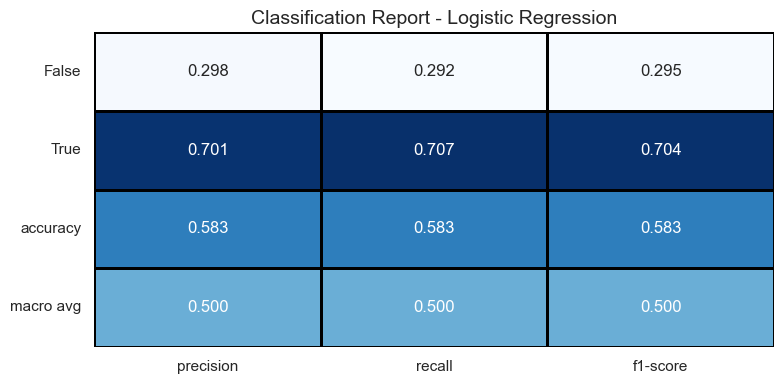

In [346]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = lr.predict(X_test)

report_dict = classification_report(y_test, y_pred_lr, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose().round(3)

report_df_display = report_df.drop(columns='support')

plt.figure(figsize=(8, 4))
sns.set(style="whitegrid")
sns.heatmap(report_df_display.iloc[:-1, :], 
            annot=True, cbar=False, cmap="Blues", fmt='.3f',
            linewidths=1, linecolor='black')

plt.title("Classification Report - Logistic Regression", fontsize=14)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [331]:
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train_smote, y_train_smote)
(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest:\n", classification_report(y_test, y_pred_rf))

#DataFrame to store metrics
rf_metrics = {
    'Accuracy': round(accuracy_score(y_test, y_pred_rf), 3),
    'Precision': round(precision_score(y_test, y_pred_rf), 3),
    'Recall': round(recall_score(y_test, y_pred_rf), 3),
    'F1 Score': round(f1_score(y_test, y_pred_rf), 3)
}

rf_results_df = pd.DataFrame(rf_metrics, index=['Random Forest'])

styled_rf_table = rf_results_df.style.set_properties(**{
    'background-color': 'white',
    'color': 'black',
    'text-align': 'center',
        'border': '1px solid black'
}).set_table_styles([
    {
        'selector': 'th',
        'props': [('background-color', 'white'), ('color', 'black'), ('text-align', 'center'), ('border', '1px solid black')]
    },
    {
        'selector': 'td',
        'props': [('background-color', 'white'), ('color', 'black'), ('border', '1px solid black')]
    }
])
styled_rf_table

Random Forest:
               precision    recall  f1-score   support

       False       0.33      0.13      0.19       527
        True       0.71      0.88      0.78      1237

    accuracy                           0.66      1764
   macro avg       0.52      0.51      0.49      1764
weighted avg       0.59      0.66      0.61      1764



,Accuracy,Precision,Recall,F1 Score
Random Forest,0.660000,0.705000,0.884000,0.785000


In [ ]:
y_pred_rf = rf.predict(X_test)
y_pred_lr = lr.predict(X_test)

def get_scores(y_true, y_pred):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred)
    }

rf_scores = get_scores(y_test, y_pred_rf)
lr_scores = get_scores(y_test, y_pred_lr)

results_df = pd.DataFrame([rf_scores, lr_scores], index=['Random Forest', 'Logistic Regression'])
results_df = results_df.round(3)

def highlight_models(row):
    if row.name == 'Random Forest':
        return ['background-color: #e0f7fa'] * len(row) 
    elif row.name == 'Logistic Regression':
        return ['background-color: #ffe0b2'] * len(row)
    else:
        return [''] * len(row)

styled_results = results_df.style.apply(highlight_models, axis=1)\
    .set_properties(**{
        'color': 'black',
        'text-align': 'center',
        'border': '1px solid black'
    })\
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', 'white'), ('color', 'black'), ('text-align', 'center'), ('border', '1px solid black')]}
    ])
styled_results

,Accuracy,Precision,Recall,F1 Score
Random Forest,0.660000,0.705000,0.884000,0.785000
Logistic Regression,0.583000,0.701000,0.707000,0.704000


Comparison between lr and rf

In [333]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, f1_score, precision_score, recall_score

y_pred = rf.predict(X_test)

y_proba = rf.predict_proba(X_test)[:, 1]

print("y_pred shape:", y_pred.shape)
print("y_test shape:", y_test.shape)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

print("MSE (using probabilities):", mean_squared_error(y_test, y_proba))
print("MAE (using probabilities):", mean_absolute_error(y_test, y_proba))

#DataFrame to store metrics
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, 
    accuracy_score, f1_score, precision_score, recall_score
)

metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred),
    'MSE (probabilities)': mean_squared_error(y_test, y_proba),
    'MAE (probabilities)': mean_absolute_error(y_test, y_proba)
}

metrics_df = pd.DataFrame(metrics, index=['Random Forest']).T
metrics_df.columns.name = "Model"
metrics_df = metrics_df.round(3)

styled_metrics = metrics_df.style.set_properties(**{
    'background-color': 'white',
    'color': 'black',
    'text-align': 'center',
    'border': '1px solid black'
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', 'white'), ('color', 'black'), ('text-align', 'center'), ('border', '1px solid black')]}
])

styled_metrics

y_pred shape: (1764,)
y_test shape: (1764,)
Accuracy: 0.6598639455782312
F1 Score: 0.7847919655667145
Precision: 0.7053513862024501
Recall: 0.8843977364591754
MSE (using probabilities): 0.22186621315192745
MAE (using probabilities): 0.44329931972789116


Model,Random Forest
Accuracy,0.660000
Precision,0.705000
Recall,0.884000
F1 Score,0.785000
MSE (probabilities),0.222000
MAE (probabilities),0.443000


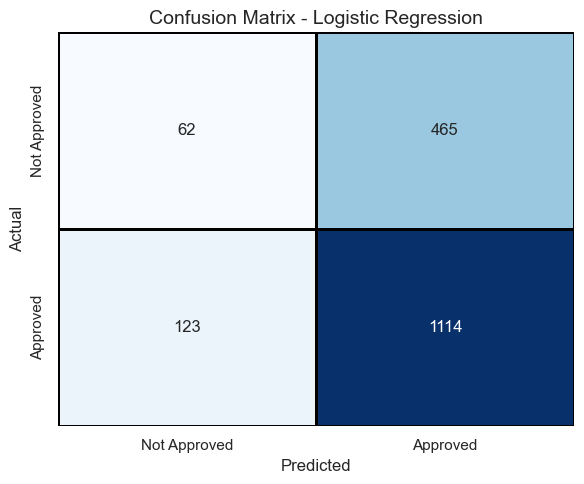

In [345]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False,
            xticklabels=['Not Approved', 'Approved'],
            yticklabels=['Not Approved', 'Approved'],
            linewidths=1, linecolor='black')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression', fontsize=14)
plt.tight_layout()
plt.show()

visualise true/false positives/negatives and compares predicted value and actual value

Best Params: {'max_depth': None, 'n_estimators': 200}
Best CV Score: 0.8073186069786857
Tuned Random Forest:
               precision    recall  f1-score   support

       False       0.34      0.12      0.17       527
        True       0.71      0.90      0.79      1237

    accuracy                           0.67      1764
   macro avg       0.52      0.51      0.48      1764
weighted avg       0.59      0.67      0.61      1764



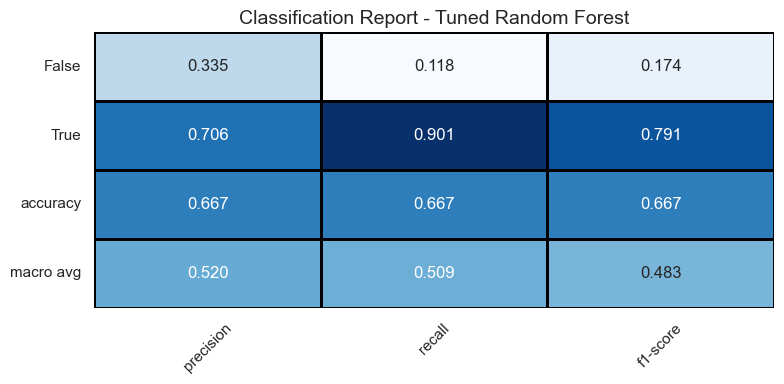

In [ ]:
from sklearn.model_selection import GridSearchCV

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10]
}
grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='f1', 
    n_jobs=-1
)

grid.fit(X_train_smote, y_train_smote)

best_rf = grid.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)

print("Best Params:", grid.best_params_)
print("Best CV Score:", grid.best_score_)
print("Tuned Random Forest:\n", classification_report(y_test, y_pred_best_rf))

#DataFrame to store metrics
report_dict_rf = classification_report(y_test, y_pred_best_rf, output_dict=True)
report_df_rf = pd.DataFrame(report_dict_rf).transpose().round(3)

report_df_display = report_df_rf.drop(columns='support')

plt.figure(figsize=(8, 4))
sns.set(style="whitegrid")
sns.heatmap(report_df_display.iloc[:-1, :], 
            annot=True, fmt=".3f", cmap="Blues", cbar=False,
            linewidths=1, linecolor='black')

plt.title("Classification Report - Tuned Random Forest", fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Fidn best parameters to improve modeal perforance

Classification Report:
               precision    recall  f1-score   support

       False       0.34      0.12      0.17       527
        True       0.71      0.90      0.79      1237

    accuracy                           0.67      1764
   macro avg       0.52      0.51      0.48      1764
weighted avg       0.59      0.67      0.61      1764

F1 Score: 0.7911931818181818


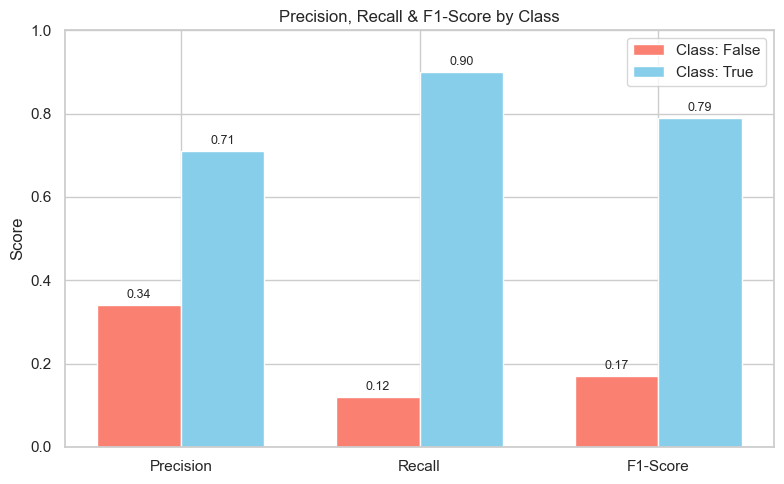

In [336]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

y_pred = best_rf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

metrics = {
    "False": {"Precision": 0.34, "Recall": 0.12, "F1-Score": 0.17},
    "True": {"Precision": 0.71, "Recall": 0.90, "F1-Score": 0.79}
}

labels = list(metrics["False"].keys())
x = np.arange(len(labels)) 
width = 0.35 

false_scores = [metrics["False"][label] for label in labels]
true_scores = [metrics["True"][label] for label in labels]

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, false_scores, width, label='Class: False', color='salmon')
bars2 = ax.bar(x + width/2, true_scores, width, label='Class: True', color='skyblue')

ax.set_ylabel('Score')
ax.set_title('Precision, Recall & F1-Score by Class')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1.0)
ax.legend()

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

evaluate best model with F1 score

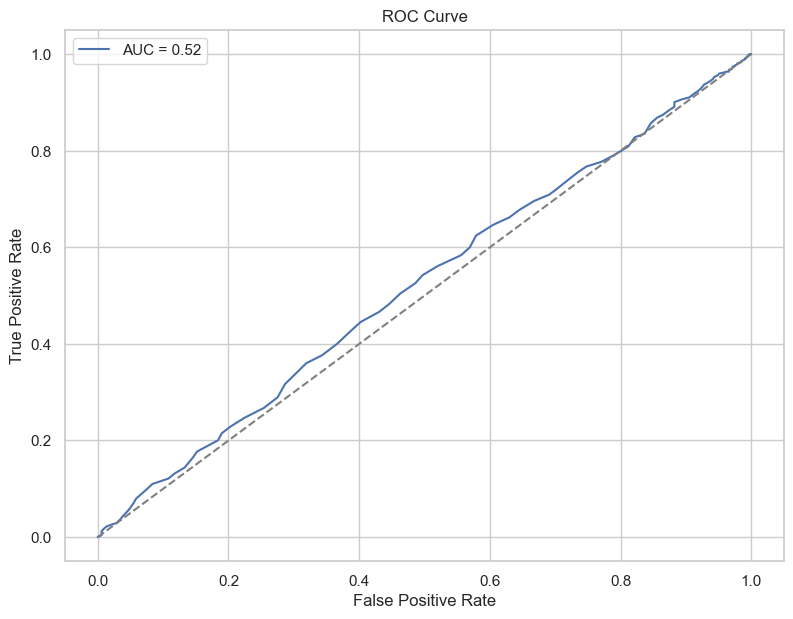

In [337]:
from sklearn.metrics import roc_curve, roc_auc_score

y_proba = best_rf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8, 6))
plt.grid(True)
plt.tight_layout()
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


ROC measures model ability to discriminate between classes.
An AUC of 0.52 is only slightly better than random guessing which suggests that the model is unable to effectively differentiate between approved and not approved loans, likely due to imbalanceed classes.

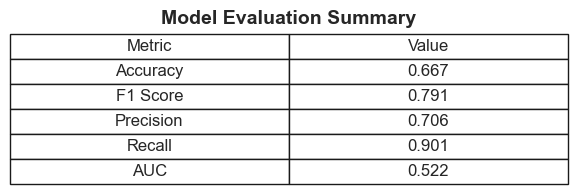

In [338]:
metrics = {
    "Accuracy": round(accuracy_score(y_test, y_pred_best_rf), 3),
    "F1 Score": round(f1_score(y_test, y_pred_best_rf), 3),
    "Precision": round(precision_score(y_test, y_pred_best_rf), 3),
    "Recall": round(recall_score(y_test, y_pred_best_rf), 3),
    "AUC": round(auc_score, 3)
}

fig, ax = plt.subplots(figsize=(6, 2))
ax.axis('tight')
ax.axis('off')

table_data = [[k, v] for k, v in metrics.items()]
table = ax.table(
    cellText=table_data, 
    colLabels=["Metric", "Value"],
    loc='center', 
    cellLoc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.5)

plt.title("Model Evaluation Summary", fontsize=14, weight='bold')
plt.show()

Consolidation table of final scores

In [339]:
import joblib

joblib.dump(best_rf, 'model.pkl')


['model.pkl']

I used Random Forest as it has the best model with the better accuracy of 0.67.

In [340]:
model = joblib.load('model.pkl')